In [1]:
import pandas as pd

In [3]:
data = pd.read_csv('../data/deputat_daily_features.csv').dropna()
data.head()

,Unnamed: 0,deputat,party,present,date,Year,Month,Week,Day,Dayofweek,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,present_last_ass,present_last_5ass
5,5,АДЛЕН ШУКРИ ШЕВКЕД,ДПС,False,2019-01-24,2019,1,4,24,3,False,False,False,False,False,False,0.0,0.6
6,6,АДЛЕН ШУКРИ ШЕВКЕД,ДПС,False,2019-01-25,2019,1,4,25,4,False,False,False,False,False,False,0.0,0.4
7,7,АДЛЕН ШУКРИ ШЕВКЕД,ДПС,False,2019-01-30,2019,1,5,30,2,False,False,False,False,False,False,0.0,0.4
8,8,АДЛЕН ШУКРИ ШЕВКЕД,ДПС,False,2019-01-31,2019,1,5,31,3,True,False,False,False,False,False,0.0,0.2
9,9,АДЛЕН ШУКРИ ШЕВКЕД,ДПС,False,2019-02-01,2019,2,5,1,4,False,True,False,False,False,False,0.0,0.0


In [6]:
numerical_features = ['present_last_ass', 'present_last_5ass']
categorical_features = ['party']

features_df = data[numerical_features].copy()

for cat_feat in categorical_features:
    dummies = pd.get_dummies(data[cat_feat], prefix=cat_feat)
    display(f"dummy for {cat_feat} is {dummies.columns[0]}")
    dummies = dummies.drop(columns=dummies.columns[:1])
    features_df = pd.concat([features_df, dummies],axis=1)

    
features_df['bias'] = 1
features_df.head()

'dummy for party is party_ВОЛЯ'

,present_last_ass,present_last_5ass,party_ГЕРБ,party_ДПС,party_НЕЗ,party_ОП,party_ПГБСП,bias
5,0.0,0.6,0,1,0,0,0,1
6,0.0,0.4,0,1,0,0,0,1
7,0.0,0.4,0,1,0,0,0,1
8,0.0,0.2,0,1,0,0,0,1
9,0.0,0.0,0,1,0,0,0,1


In [4]:
from sklearn.neural_network import MLPClassifier

In [23]:
model = MLPClassifier(hidden_layer_sizes=(50,20))

In [24]:
model.fit(features_df.values, data['present'])

MLPClassifier(hidden_layer_sizes=(50, 20))

In [25]:
model.score(features_df.values, data['present'])

0.748209887151286

In [26]:
predictions = model.predict_proba(features_df.values)[:,1]

In [46]:
from sklearn.inspection import partial_dependence,plot_partial_dependence
import matplotlib.pyplot as plt

In [42]:
before = model.predict_proba(features_df.values).mean()
afters = []
for feat_value in [0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9, 1.]:    
    partial_dep = features_df.copy()
    partial_dep['present_last_5ass'] = feat_value
    after = model.predict_proba(partial_dep.values)[:,1].mean()
    afters.append(after)
    
before, afters

(0.4999999999999999,
 [0.21844824323650627,
  0.29103964881107053,
  0.36987487789107787,
  0.43091078327504895,
  0.4884395187856266,
  0.5455607575487206,
  0.6014140933101138,
  0.6551682622153713,
  0.7072964471410539,
  0.7531462619823235,
  0.7897367382520187])

In [44]:
features_df.columns

Index(['present_last_ass', 'present_last_5ass', 'party_ГЕРБ', 'party_ДПС',
       'party_НЕЗ', 'party_ОП', 'party_ПГБСП', 'bias'],
      dtype='object')

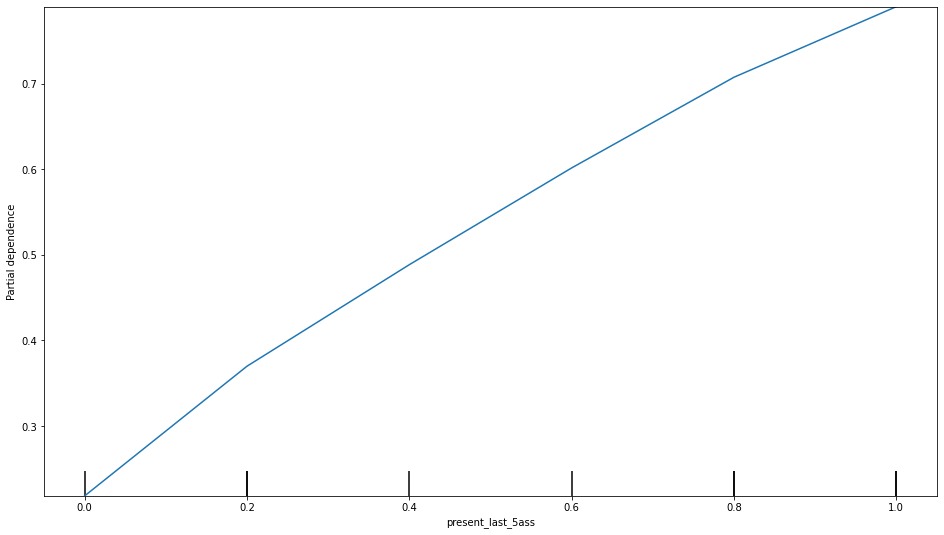

In [45]:
fig, ax = plt.subplots(figsize=(16,9))
plot_partial_dependence(model,features_df.values,feature_names=features_df.columns, features=["present_last_5ass"],ax=ax);